In [1]:
import torch
from PIL import Image
from sklearn.model_selection import train_test_split
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision.transforms.functional as transF
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import os
from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
import cv2
from albumentations.pytorch import ToTensorV2
from skimage import io, transform
from skimage.io import imread, imshow
import cv2
from PIL import Image
from torch.utils.data import random_split
from tqdm import tqdm

In [2]:
!mkdir train_data test_data
!unzip -qq ../input/data-science-bowl-2018/stage1_train.zip -d train_data
!unzip -qq ../input/data-science-bowl-2018/stage1_test.zip -d test_data

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
class CFG:
    size = 128
    mean = [43.5334, 39.5612, 48.2250]
    std = [67.0821, 61.8689, 75.3638]
    batch_size = 10

In [5]:
def get_transforms(mean=CFG.mean, std=CFG.std):
            return Compose([
                            HorizontalFlip(p=0.5),
                            Normalize(mean=mean, std=std, p=1),
                            ToTensorV2(transpose_mask=True)
                            ])

In [6]:
class CustomDataset(Dataset):
    def __init__(self,path):
        self.path = path
        self.folders = os.listdir(path)
        print(len(self.folders))
        self.transforms = get_transforms()
    def __getitem__(self,idx):
        image_folder = os.path.join(self.path,self.folders[idx],'images/')
        mask_folder = os.path.join(self.path,self.folders[idx],'masks/')
        image_path = os.path.join(image_folder,os.listdir(image_folder)[0])
    
        img = io.imread(image_path)[:,:,:3].astype('float32')
        img = transform.resize(img,(128,128))
        mask = self.get_mask(mask_folder, 128 ).astype('float32')
    
        augmented = self.transforms(image=img, mask=mask)
        img = augmented['image']
        mask = augmented['mask']
        return (img,mask) 

    def get_mask(self,mask_folder, img_size):
        mask = np.zeros((img_size, img_size, 1), dtype=np.bool)
        for mask_ in os.listdir(mask_folder):
            mask_ = io.imread(os.path.join(mask_folder,mask_))
            mask_ = transform.resize(mask_, (img_size, img_size))
            mask_ = np.expand_dims(mask_,axis=-1)
            mask = np.maximum(mask, mask_)
        return mask

    def __len__(self):
        return len(self.folders)

In [24]:
base_dir = './train_data'
data = CustomDataset(base_dir)
for image,mask in data:
    print(image.shape)
    print(mask.shape)
    break

670
torch.Size([3, 128, 128])
torch.Size([1, 128, 128])


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [8]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

unorm = UnNormalize(mean = CFG.mean, std = CFG.std)

In [9]:
train_len = int(0.9*len(data))
val_len = len(data)-train_len
train_data, val_data = random_split(data, [train_len,val_len])
train_loader = DataLoader(dataset=train_data, batch_size=CFG.batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=CFG.batch_size)
print(len(train_loader),len(val_loader))

61 7


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


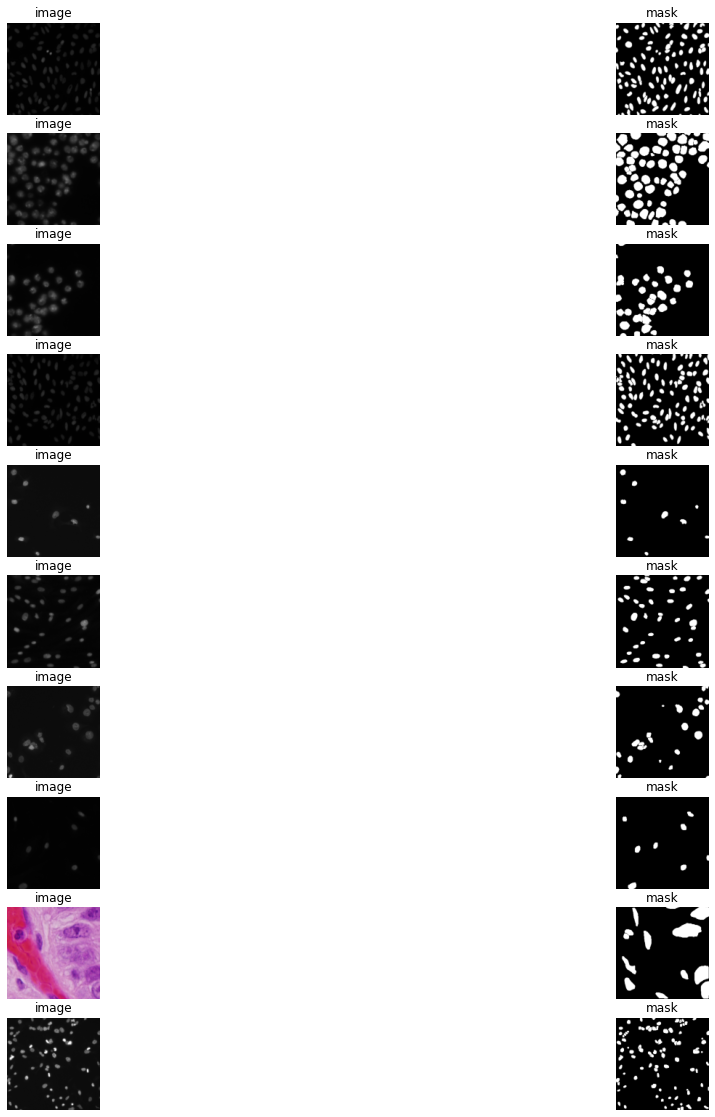

In [10]:
plt.figure(figsize=(20,20))
for (images,labels) in train_loader:
    for i, (image, label) in enumerate(zip(images,labels)):
        plt.subplot(10, 2, 2*i+1)
        plt.axis('off')
        temp = unorm(image.clone())
        plt.title('image')
        plt.imshow( temp.permute(1, 2, 0))
        
        plt.subplot(10, 2, 2*i+2)
        plt.axis('off')
        temp = unorm(label.clone())
        plt.title('mask')
        plt.imshow( temp.squeeze(0),cmap='gray')
    plt.show()
    break

In [11]:
def calculate_iou(y_pred,y):
    inputs = y_pred.reshape(-1)
    targets = y.reshape(-1)
    intersection = (inputs * targets).sum()
    total = (inputs + targets).sum()
    union = total - intersection 
    smooth = 1    
    iou = (intersection + smooth)/(union + smooth)
    return iou



def calculate_iou_batch(y_pred,y):
    ious = []
    y_pred = torch.sigmoid(y_pred)
    y_pred = y_pred.clone().cpu().detach().numpy()
    y = y.clone().cpu().detach().numpy() 
    
    for pred, label in zip(y_pred, y):
        ious.append(calculate_iou(pred, label))
    iou = np.nanmean(ious)
    return iou   

In [12]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)
    
    
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)

    
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode):
        super(UpBlock, self).__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=2, stride=2)        
        elif up_sample_mode == 'bilinear':
            self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)

    
class UNet(nn.Module):
    def __init__(self, out_classes=1, up_sample_mode='conv_transpose'):
        super(UNet, self).__init__()
        self.up_sample_mode = up_sample_mode
        # Downsampling Path
        self.down_conv1 = DownBlock(3, 64)
        self.down_conv2 = DownBlock(64, 128)
        self.down_conv3 = DownBlock(128, 256)
        self.down_conv4 = DownBlock(256, 512)
        # Bottleneck
        self.double_conv = DoubleConv(512, 1024)
        # Upsampling Path
        self.up_conv4 = UpBlock(512 + 1024, 512, self.up_sample_mode)
        self.up_conv3 = UpBlock(256 + 512, 256, self.up_sample_mode)
        self.up_conv2 = UpBlock(128 + 256, 128, self.up_sample_mode)
        self.up_conv1 = UpBlock(128 + 64, 64, self.up_sample_mode)
        # Final Convolution
        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        return x

In [13]:
model = UNet().to(device)
image = torch.rand((1,3,128,128)).to(device)
model(image).shape

torch.Size([1, 1, 128, 128])

In [14]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        bce_weight = 0.5
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        loss_final = BCE * bce_weight + dice_loss * (1 - bce_weight)
        return loss_final 

In [15]:
learning_rate = 3e-4
optimizer = optim.Adam(model.parameters(),lr= learning_rate)
criterion = DiceBCELoss()
epochs = 25

In [16]:
def train(model, train_loader):
    model.train()
    train_loss, train_score, target_count = 0, 0, 0
    
    for images, masks in tqdm(train_loader):
        images = images.to(device)
        masks  = masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        score = calculate_iou_batch(outputs,masks)
        train_loss += loss.item()
        train_score += score
        target_count += masks.shape[0]
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return train_loss/target_count, train_score / target_count

In [17]:
def validate(model,val_loader):
    model.eval()
    val_loss, val_score, target_count = 0, 0, 0
    for images, masks in val_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)
        score = calculate_iou_batch(outputs,masks)
        val_loss += loss.item()
        val_score += score
        target_count += masks.shape[0]

    return val_loss/target_count, val_score / target_count

In [18]:
train_loss_history,val_loss_history = [],[]
train_iou_history,val_iou_history = [],[]
min_val_loss = 1e9
checkpoint_path = 'checkpoint'

for epoch in range(epochs):
    train_loss, train_score = train(model, train_loader)
    val_loss, val_score = validate(model, val_loader)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_iou_history.append(train_score)
    val_iou_history.append(val_score)
    print("Epoch {0}: train_score {1} \t train_loss {2} \t val_score {3} \t val_loss {4}".format(epoch, train_score, train_loss, val_score, val_loss))
    if val_loss < min_val_loss:
        checkpoint = {
                'epoch': epoch + 1,
                'valid_loss_min': val_loss,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
            }
        torch.save(checkpoint,checkpoint_path)
        min_val_loss = val_loss

  0%|          | 0/61 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
100%|██████████| 61/61 [03:31<00:00,  3.46s/it]


Epoch 0: train_score 0.020884907194118795 	 train_loss 0.05221763164249819 	 val_score 0.026090069069525813 	 val_loss 0.04675547934290188


100%|██████████| 61/61 [03:31<00:00,  3.46s/it]


Epoch 1: train_score 0.033908326224495404 	 train_loss 0.03395141910755417 	 val_score 0.01783717373951176 	 val_loss 0.10113193472819541


100%|██████████| 61/61 [03:28<00:00,  3.42s/it]


Epoch 2: train_score 0.04073191547061032 	 train_loss 0.027679624965732567 	 val_score 0.02496063566673604 	 val_loss 0.06666217277299112


100%|██████████| 61/61 [03:27<00:00,  3.40s/it]


Epoch 3: train_score 0.04677437876694664 	 train_loss 0.02276192652447702 	 val_score 0.020169619587436887 	 val_loss 0.11725854339884288


100%|██████████| 61/61 [03:27<00:00,  3.40s/it]


Epoch 4: train_score 0.05128862023015392 	 train_loss 0.020290197894150146 	 val_score 0.02811148680279411 	 val_loss 0.07285591648585761


100%|██████████| 61/61 [03:28<00:00,  3.42s/it]


Epoch 5: train_score 0.05434685514263351 	 train_loss 0.018771147574753705 	 val_score 0.006778598865964556 	 val_loss 0.08474002489403112


100%|██████████| 61/61 [03:28<00:00,  3.42s/it]


Epoch 6: train_score 0.05853991731332859 	 train_loss 0.016447547903503747 	 val_score 0.03669995558797965 	 val_loss 0.04310419221422566


100%|██████████| 61/61 [03:22<00:00,  3.33s/it]


Epoch 7: train_score 0.0612148460441528 	 train_loss 0.01560842494169871 	 val_score 0.009341201638470575 	 val_loss 0.07022772351307656


100%|██████████| 61/61 [03:23<00:00,  3.33s/it]


Epoch 8: train_score 0.06146294397837343 	 train_loss 0.01606888536543 	 val_score 0.017785846920490282 	 val_loss 0.12447374792241339


100%|██████████| 61/61 [03:23<00:00,  3.33s/it]


Epoch 9: train_score 0.06418630619798335 	 train_loss 0.014643232892599469 	 val_score 0.02367110745195146 	 val_loss 0.05574628577303531


100%|██████████| 61/61 [03:23<00:00,  3.34s/it]


Epoch 10: train_score 0.06603735541773444 	 train_loss 0.013970290423428044 	 val_score 0.04359099790449824 	 val_loss 0.04276211982342734


100%|██████████| 61/61 [03:27<00:00,  3.40s/it]


Epoch 11: train_score 0.06700616097891834 	 train_loss 0.013589930549189819 	 val_score 0.05323195490282731 	 val_loss 0.024627245629011696


100%|██████████| 61/61 [03:26<00:00,  3.39s/it]


Epoch 12: train_score 0.06733424031051227 	 train_loss 0.013614677214009647 	 val_score 0.029342959443101724 	 val_loss 0.047707519424495415


100%|██████████| 61/61 [03:25<00:00,  3.36s/it]


Epoch 13: train_score 0.06899731731746633 	 train_loss 0.012821287806354352 	 val_score 0.034330050892962594 	 val_loss 0.04023646285284811


100%|██████████| 61/61 [03:24<00:00,  3.36s/it]


Epoch 14: train_score 0.06948811143925135 	 train_loss 0.012729102551047481 	 val_score 0.03374032752126277 	 val_loss 0.042393274271666115


100%|██████████| 61/61 [03:24<00:00,  3.35s/it]


Epoch 15: train_score 0.06955965802495014 	 train_loss 0.012817335959097639 	 val_score 0.024758546052187105 	 val_loss 0.05057510199831493


100%|██████████| 61/61 [03:23<00:00,  3.33s/it]


Epoch 16: train_score 0.07033955154227865 	 train_loss 0.012475855178995117 	 val_score 0.035485092301571625 	 val_loss 0.045993502905119714


100%|██████████| 61/61 [03:23<00:00,  3.34s/it]


Epoch 17: train_score 0.07013781008611265 	 train_loss 0.012741899646040219 	 val_score 0.01769918748820935 	 val_loss 0.262117012223201


100%|██████████| 61/61 [03:24<00:00,  3.35s/it]


Epoch 18: train_score 0.07042303301784977 	 train_loss 0.012565858587993318 	 val_score 0.01191559868216789 	 val_loss 0.06779714929523753


100%|██████████| 61/61 [03:23<00:00,  3.33s/it]


Epoch 19: train_score 0.07133672976268039 	 train_loss 0.012148813587021867 	 val_score 0.02369119615391003 	 val_loss 0.07190204734232888


100%|██████████| 61/61 [03:22<00:00,  3.32s/it]


Epoch 20: train_score 0.07125712723838984 	 train_loss 0.012223184615324187 	 val_score 0.023454410793990976 	 val_loss 0.05439855091607393


100%|██████████| 61/61 [03:23<00:00,  3.34s/it]


Epoch 21: train_score 0.0717405104159092 	 train_loss 0.011957704341332514 	 val_score 0.010166359086603348 	 val_loss 0.08246138113648144


100%|██████████| 61/61 [03:25<00:00,  3.37s/it]


Epoch 22: train_score 0.07229658957181723 	 train_loss 0.01188173157411626 	 val_score 0.014589733341082064 	 val_loss 0.0680560825476006


100%|██████████| 61/61 [03:31<00:00,  3.48s/it]


Epoch 23: train_score 0.07209298867938584 	 train_loss 0.011993526671063248 	 val_score 0.04007337860607361 	 val_loss 0.03878529347590546


100%|██████████| 61/61 [03:22<00:00,  3.31s/it]


Epoch 24: train_score 0.07272603252436256 	 train_loss 0.011663349410194663 	 val_score 0.022986761707302607 	 val_loss 0.0642667056909248


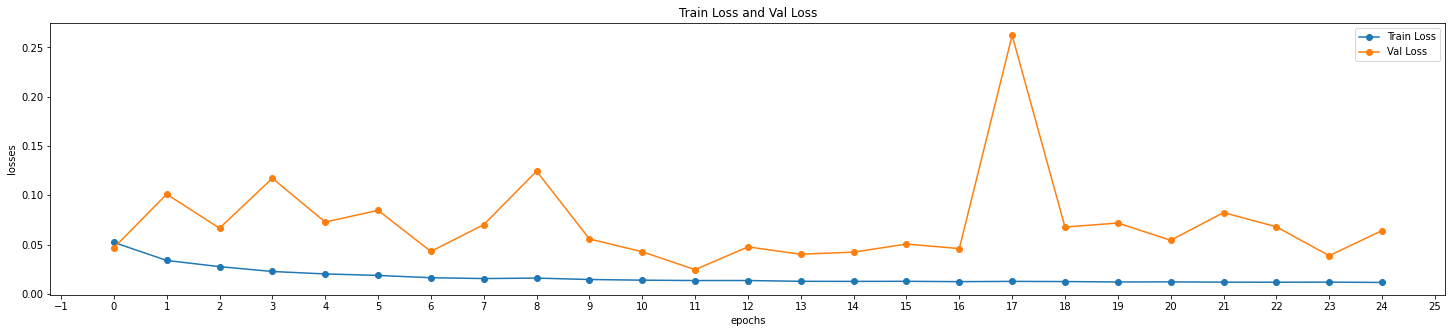

In [19]:
plt.figure(figsize=(25,5))
plt.plot(train_loss_history,'-o')
plt.plot(val_loss_history,'-o')
plt.xlabel('epochs')
plt.ylabel('losses')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.legend(['Train Loss','Val Loss'])
plt.title('Train Loss and Val Loss')
plt.show()

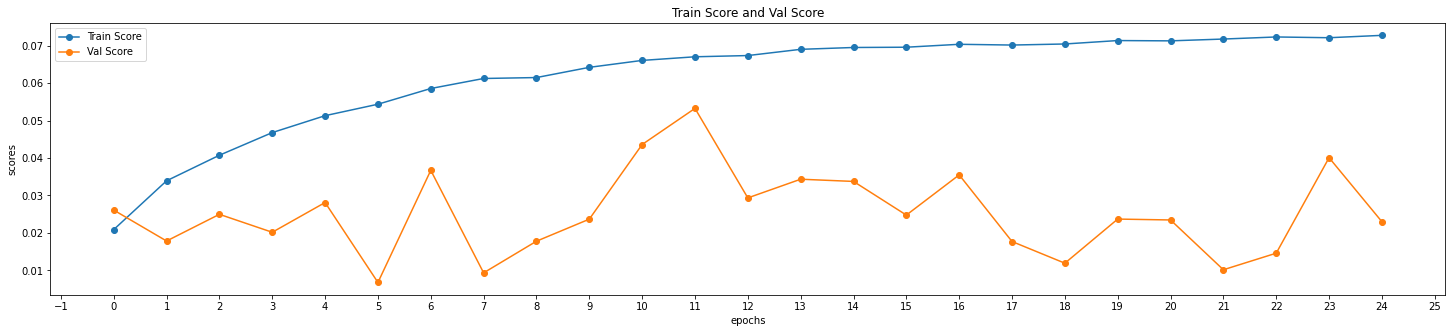

In [20]:
plt.figure(figsize=(25,5))
plt.plot(train_iou_history,'-o')
plt.plot(val_iou_history,'-o')
plt.xlabel('epochs')
plt.ylabel('scores')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.legend(['Train Score','Val Score'])
plt.title('Train Score and Val Score')
plt.show()

In [21]:
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [22]:
images,masks = next(iter(val_loader))
print(images.shape,masks.shape)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


torch.Size([10, 3, 128, 128]) torch.Size([10, 1, 128, 128])


torch.Size([10, 3, 128, 128]) torch.Size([10, 1, 128, 128]) torch.Size([10, 1, 128, 128])


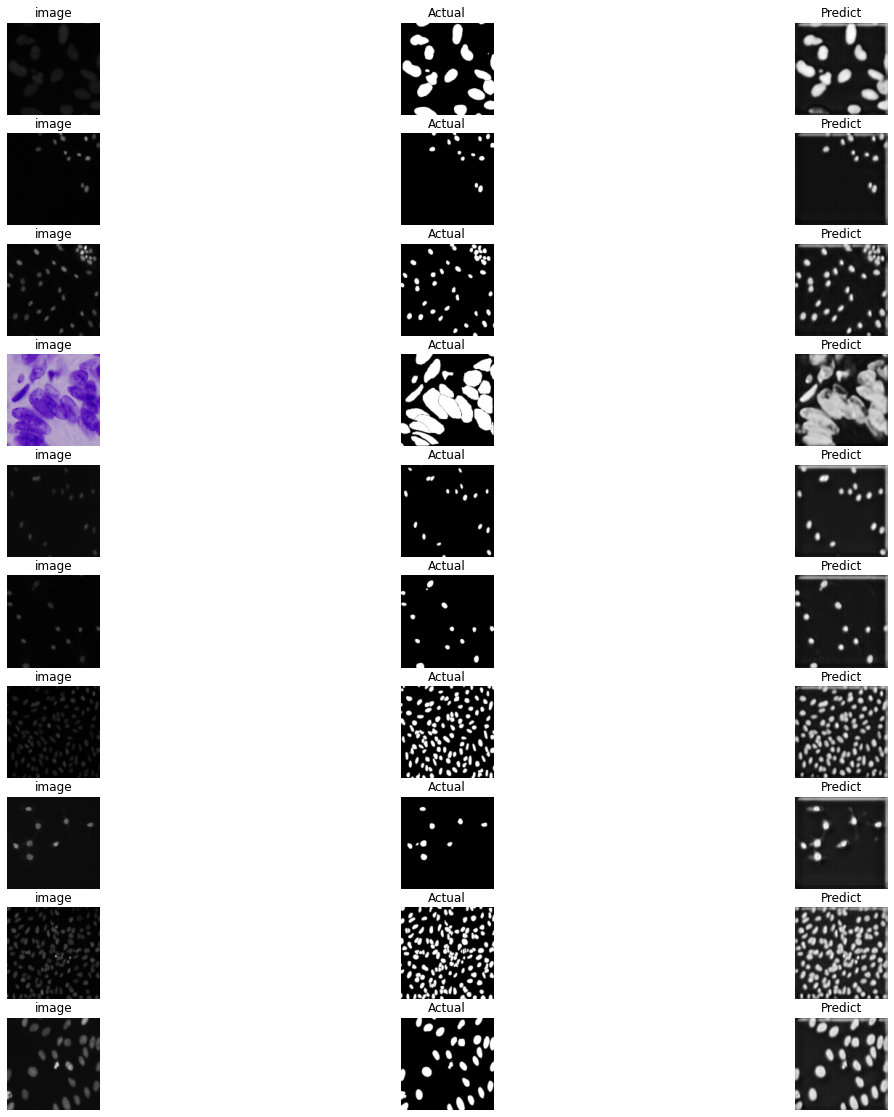

In [23]:
images = images.to(device)
predict_masks = model(images)
print(images.shape, masks.shape, predict_masks.shape)
plt.figure(figsize=(20,20))
for i, (image, mask, predict_mask) in enumerate(zip(images,masks,predict_masks)):
    plt.subplot(10, 3, i*3+1)
    plt.axis('off')
    temp = unorm(image.clone()).cpu()
    plt.title('image')
    plt.imshow( temp.permute(1, 2, 0))

    plt.subplot(10, 3, i*3+2)
    plt.axis('off')
    temp = unorm(mask.clone()).cpu()
    plt.title('Actual')
    plt.imshow( temp.squeeze(0),cmap='gray')

    plt.subplot(10, 3, i*3+3)
    plt.axis('off')
    temp = predict_mask.clone().cpu()
    plt.title('Predict')
    plt.imshow( temp.squeeze(0).detach().numpy(),cmap='gray')
plt.show()

In [25]:
class TestDataset(Dataset):
    def __init__(self,path):
        self.path = path
        self.folders = os.listdir(path)
        print(len(self.folders))
        self.transforms = get_transforms()
    def __getitem__(self,idx):
        image_folder = os.path.join(self.path,self.folders[idx],'images/')
        image_path = os.path.join(image_folder,os.listdir(image_folder)[0])
    
        img = io.imread(image_path)[:,:,:3].astype('float32')
        img = transform.resize(img,(128,128))
    
        augmented = self.transforms(image=img)
        img = augmented['image']
        return img
    def __len__(self):
        return len(self.folders)

In [28]:
test_dir = './test_data'
test_data = TestDataset(test_dir)
for image in test_data:
    print(image.shape)
    break

65
torch.Size([3, 128, 128])


In [29]:
test_loader = DataLoader(dataset=test_data, batch_size=CFG.batch_size)

torch.Size([10, 3, 128, 128]) torch.Size([10, 1, 128, 128])


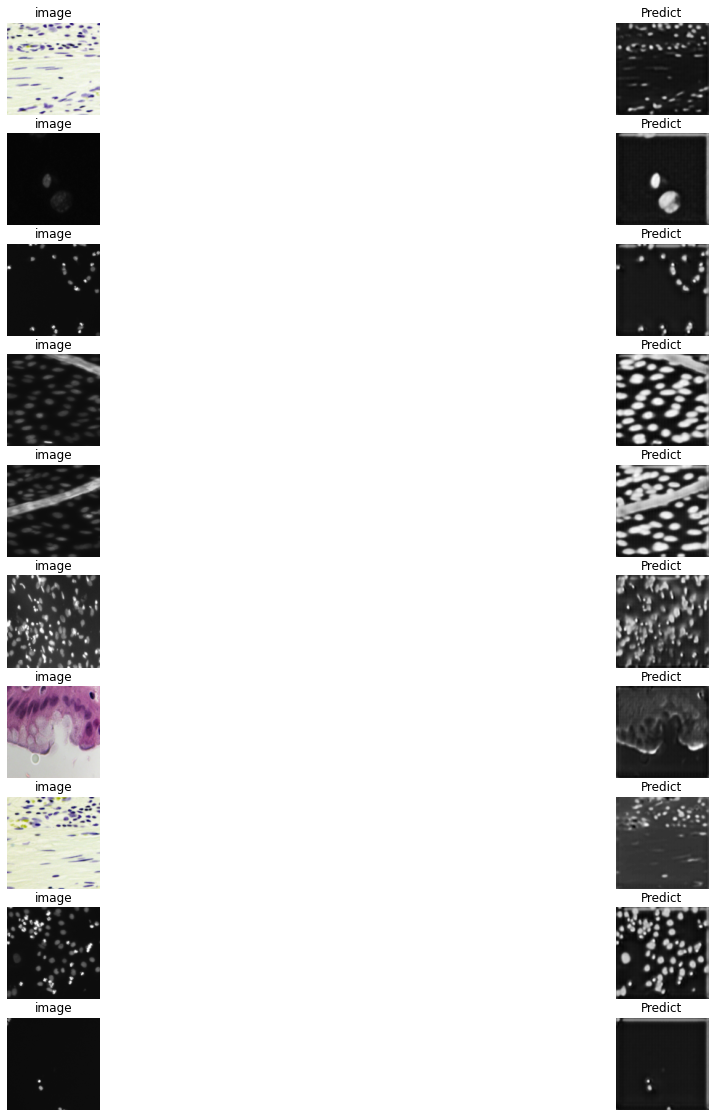

In [35]:
images = next(iter(test_loader))
images = images.to(device)
predict_masks = model(images)
print(images.shape, predict_masks.shape)
plt.figure(figsize=(20,20))
for i, (image, predict_mask) in enumerate(zip(images,predict_masks)):
    plt.subplot(10, 2, i*2+1)
    plt.axis('off')
    temp = unorm(image.clone()).cpu()
    plt.title('image')
    plt.imshow( temp.permute(1, 2, 0))

    plt.subplot(10, 2, i*2+2)
    plt.axis('off')
    temp = predict_mask.clone().cpu()
    plt.title('Predict')
    plt.imshow( temp.squeeze(0).detach().numpy(),cmap='gray')
plt.show()